In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [12]:
df = pd.read_csv('../Data/processed_data/all_final_for_model.csv')
X = df.drop(['fare_to_predict'], axis=1)
y = df.fare_to_predict

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
lst = X_test.index.tolist()
json.dump(lst, open("../Data/precomputes/test_indices.json", 'w'))

In [3]:
test_indices = json.load(open("../Data/precomputes/test_indices.json"))
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
X_train, y_train = X.drop(test_indices), y.drop(test_indices)

In [15]:
df.head()

,if_offering_catering,if_dynamic_fare,fare_to_predict,1A,2A,2S,3A,CC,SL,distance,duration
0,False,False,1390,False,True,False,False,False,False,179,203.0
1,False,False,1010,False,False,False,True,False,False,179,203.0
2,False,False,365,False,False,False,False,False,True,179,203.0
3,False,False,1390,False,True,False,False,False,False,436,420.0
4,False,False,1010,False,False,False,True,False,False,436,420.0


In [16]:
df.dtypes

if_offering_catering       bool
if_dynamic_fare            bool
fare_to_predict           int64
1A                         bool
2A                         bool
2S                         bool
3A                         bool
CC                         bool
SL                         bool
distance                  int64
duration                float64
dtype: object

In [17]:
df[df['2S']==1][['distance', 'duration', 'fare_to_predict']].head(100)

,distance,duration,fare_to_predict
244,128,130.0,70
247,179,173.0,85
250,210,196.0,90
253,227,209.0,100
256,252,265.0,105
...,...,...,...
529,310,319.0,120
532,330,334.0,130
535,354,371.0,140
538,14,18.0,60


In [18]:
X.groupby(['if_dynamic_fare', 'if_offering_catering'])['distance'].count()*100/len(X)

if_dynamic_fare  if_offering_catering
False            False                   97.741346
                 True                     1.161248
True             False                    0.343695
                 True                     0.753711
Name: distance, dtype: float64

In [19]:
# not a balanced dataset. Let's look at 2S distance, duration, price
X[['1A', '2A', '2S', 'CC', 'SL', '3A']].value_counts()*100/len(df)

1A     2A     2S     CC     SL     3A   
False  False  False  False  True   False    29.866427
                            False  True     27.057365
       True   False  False  False  False    25.687854
True   False  False  False  False  False    11.334490
False  False  False  True   False  False     3.141290
              True   False  False  False     2.912573
Name: count, dtype: float64

In [20]:
X_train[['1A', '2A', '2S', 'CC', 'SL', '3A']].value_counts()*100/len(df)

1A     2A     2S     CC     SL     3A   
False  False  False  False  True   False    23.893452
                            False  True     21.643785
       True   False  False  False  False    20.529023
True   False  False  False  False  False     9.069948
False  False  False  True   False  False     2.512164
              True   False  False  False     2.351629
Name: count, dtype: float64

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Coefficients: \n', model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f%%' % (r2_score(y_test, y_pred) * 100))

Coefficients: 
 [ 6.07293278e+02  2.63948874e+02 -1.22906163e+12 -1.22906163e+12
 -1.22906163e+12 -1.22906163e+12 -1.22906163e+12 -1.22906163e+12
  1.02625624e+00 -9.75121939e-02]
Mean squared error: 98487.03
Coefficient of determination (R^2): 86.23%


In [48]:
mu = y_train.mean()
sigma = y_train.std()
y_train_scaled = (y_train-mu)/sigma
y_test_scaled = (y_test-mu)/sigma

scaler = StandardScaler()
X_train_scaled, X_test_scaled = X_train, X_test
X_train_scaled[['distance', 'duration']] = scaler.fit_transform(X_train[['distance', 'duration']])
X_test_scaled[['distance', 'duration']] = scaler.transform(X_test[['distance', 'duration']])

In [49]:
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train_scaled)
print(f"Model Intercept: {round(model_scaled.intercept_, 3)}")
for col, coef in zip(X.columns, model_scaled.coef_):
    print(f'{col}: {round(coef, 3)}')

Model Intercept: 1443811411.144
if_offering_catering: 0.713
if_dynamic_fare: 0.31
1A: -1443811409.774
2A: -1443811410.765
2S: -1443811411.727
3A: -1443811411.234
CC: -1443811411.477
SL: -1443811411.875
distance: 0.66
duration: -0.066


In [50]:
model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f%%' % (r2_score(y_test, y_pred) * 100))

Mean squared error: 33314.72
Coefficient of determination (R^2): 95.34%


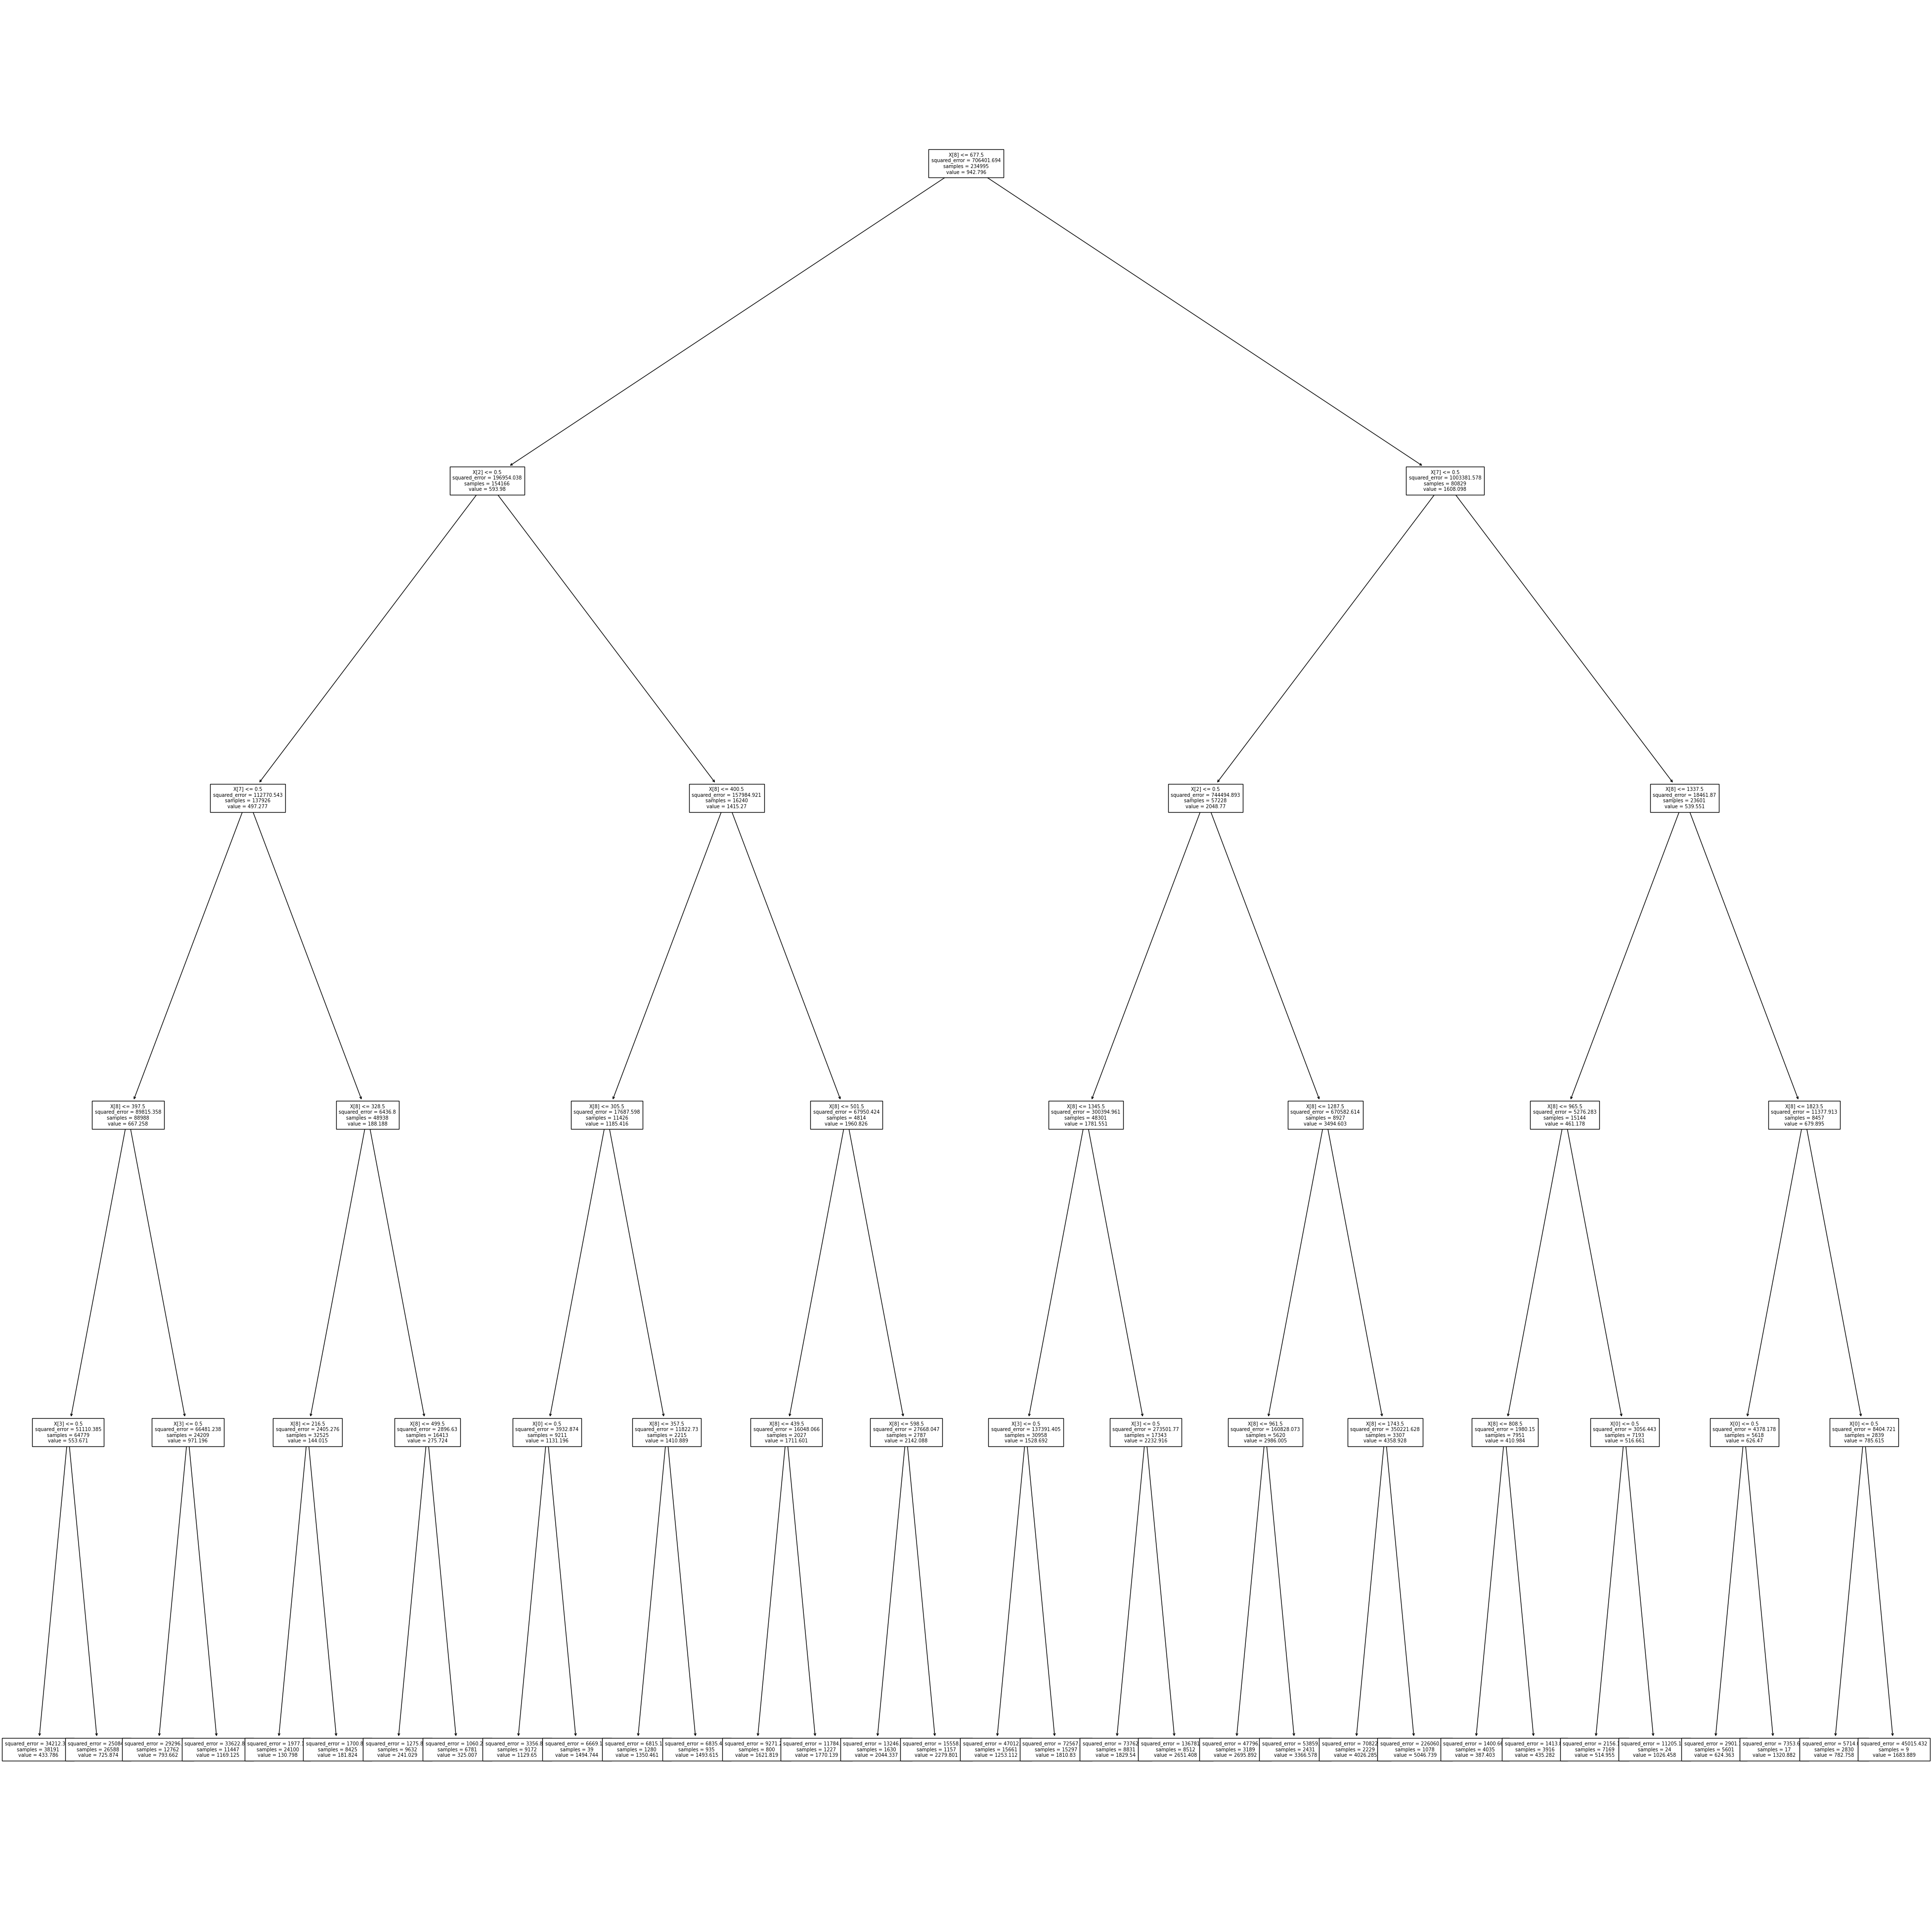

In [14]:
plt.figure(figsize=(50, 50))
tree.plot_tree(model_tree, fontsize=7)
plt.savefig("insights/output.png")

In [51]:
model_rf = RandomForestRegressor(n_estimators=5, max_depth=5)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f%%' % (r2_score(y_test, y_pred) * 100))

Mean squared error: 31288.00
Coefficient of determination (R^2): 95.62%


In [52]:
model_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f%%' % (r2_score(y_test, y_pred) * 100))

Mean squared error: 6818.39
Coefficient of determination (R^2): 99.05%


In [50]:
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_nn.compile(optimizer='adam', loss='mean_squared_error')
model_nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                704       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [22]:
X_train[['if_dynamic_fare', 'if_offering_catering']] = X_train[['if_dynamic_fare', 'if_offering_catering']].astype(int)
X_test[['if_dynamic_fare', 'if_offering_catering']] = X_test[['if_dynamic_fare', 'if_offering_catering']].astype(int)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_16036\232393926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['if_dynamic_fare', 'if_offering_catering']] = X_test[['if_dynamic_fare', 'if_offering_catering']].astype(int)


In [51]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
cp = tf.keras.callbacks.ModelCheckpoint("weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5", 
                                        save_best_only=True, verbose=1, mode='max')
history = model_nn.fit(X_train, y_train, epochs=50, validation_split=.33, callbacks=[es, cp])

Epoch 1/50
4908/4921 [============================>.] - ETA: 0s - loss: 312779.2188
Epoch 1: val_loss improved from -inf to 97120.57031, saving model to weights-improvement-01-97120.57.hdf5
4921/4921 [==============================] - 13s 3ms/step - loss: 312257.2500 - val_loss: 97120.5703
Epoch 2/50
4893/4921 [============================>.] - ETA: 0s - loss: 63307.8555
Epoch 2: val_loss did not improve from 97120.57031
4921/4921 [==============================] - 9s 2ms/step - loss: 63146.0234 - val_loss: 28426.5332
Epoch 3/50
4893/4921 [============================>.] - ETA: 0s - loss: 31397.2871
Epoch 3: val_loss did not improve from 97120.57031
4921/4921 [==============================] - 11s 2ms/step - loss: 31388.0918 - val_loss: 18595.5391
Epoch 4/50
4920/4921 [============================>.] - ETA: 0s - loss: 25771.6914
Epoch 4: val_loss did not improve from 97120.57031
4921/4921 [==============================] - 14s 3ms/step - loss: 25775.0371 - val_loss: 10935.2393
Epoch 5/

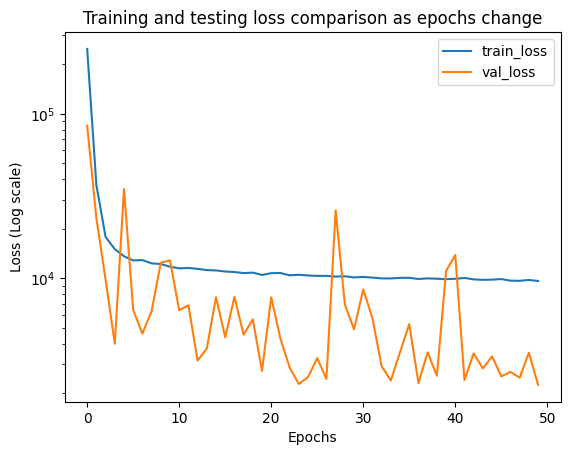

In [46]:
plt.plot(history.epoch, history.history['loss'], label='train_loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.title("Training and testing loss comparison as epochs change")
plt.xlabel("Epochs")
plt.ylabel("Loss (Log scale)")
plt.legend()

In [91]:
y_pred = model.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f%%' % (r2_score(y_test, y_pred) * 100))

Mean squared error: 7485.33
Coefficient of determination (R^2): 98.96%


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

model_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'decision_tree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 20, 30]
        }
    },
    'gradient_boosting_regression': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    },
    'random_forest_regression': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20, 30]
        }
    }
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

scores = []

for i, (model_name, mp) in enumerate(model_params.items()):
    print(f"Running for {i}/{len(model_params)} model ({model_name})...")
    clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_iter=5)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

Running for 0/5 model (linear_regression)...


D:\LearningPython\venv\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running for 1/5 model (decision_tree_regression)...


D:\LearningPython\venv\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running for 2/5 model (support_vector_regression)...
